In [ ]:
import os
os.chdir("/data/projects/punim2016/zexianh/BudjBimStoneWallSeg-SSL")

import torch
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['savefig.dpi'] = 250
plt.rcParams['figure.dpi'] = 250

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from data.dataset import BudjBimAreaDataset
from torch.utils.data import ConcatDataset, Subset
from seg_utils import build_model

/data/gpfs/projects/punim2016/anaconda3/envs/torch/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
datasets = []

for area in ['area1', 'area2', 'area3', 'area4', 'area5', 'area6']:
    datasets.append(BudjBimAreaDataset(root='data/budjbim_area', split='test', test_area=area, img_norm=True))

combined_dataset = ConcatDataset(datasets)

indices = torch.randperm(len(combined_dataset))[:100]
dataset = Subset(combined_dataset, indices)

In [3]:
arch = 'resnet50'
backbone = 'rn50'

dino_cv_mhs_backbone = build_model(
    arch, 
    'load',
    f'./save/pretrained_weights/dino_cv/{backbone}_mhs_budjbim_pretrained/checkpoint0040.pth',
    256,
    16
)
dino_cv_mhs_backbone.fc = torch.nn.Identity()
dino_cv_mhs_backbone.to('cuda')

dino_cv_vat_backbone = build_model(
    arch, 
    'load',
    f'./save/pretrained_weights/dino_cv/{backbone}_vat_budjbim_pretrained/checkpoint0040.pth',
    256,
    16
)
dino_cv_vat_backbone.fc = torch.nn.Identity()
dino_cv_vat_backbone.to('cuda')

dino_mhs_backbone = build_model(
    arch, 
    'load',
    f'./save/pretrained_weights/dino_base/{backbone}_mhs_budjbim_pretrained/checkpoint0040.pth',
    256,
    16
)
dino_mhs_backbone.fc = torch.nn.Identity()
dino_mhs_backbone.to('cuda')

dino_vat_backbone = build_model(
    arch, 
    'load',
    f'./save/pretrained_weights/dino_base/{backbone}_vat_budjbim_pretrained/checkpoint0040.pth',
    256,
    16
)
dino_vat_backbone.fc = torch.nn.Identity()
dino_vat_backbone.to('cuda')

/data/gpfs/projects/punim2016/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Take key teacher in provided checkpoint dict
Pretrained weights found at ./save/pretrained_weights/dino_cv/rn50_mhs_budjbim_pretrained/checkpoint0040.pth and loaded with msg: _IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.1.weight', 'head.mlp.1.bias', 'head.mlp.1.running_mean', 'head.mlp.1.running_var', 'head.mlp.1.num_batches_tracked', 'head.mlp.3.weight', 'head.mlp.3.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.mlp.4.running_mean', 'head.mlp.4.running_var', 'head.mlp.4.num_batches_tracked', 'head.mlp.6.weight', 'head.mlp.6.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Initialized model 'resnet50' with self-supervised pre-trained weights.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./save/pretrained_weights/dino_cv/rn50_vat_budjbim_pretrained/checkpoint0040.pth and loaded with msg: _IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
# # Each of these will be a list of per-area lists
mhs_outputs_dino = []
vat_outputs_dino = []

mhs_outputs_dino_cv = []
vat_outputs_dino_cv = []

# # Per-area feature lists
area_mhs_dino = []
area_vat_dino = []

area_mhs_dino_cv = []
area_vat_dino_cv = []

for i in range(len(dataset)):
    data = dataset[i]

    # Load data
    mhs = data['mhs'].unsqueeze(0).to('cuda')  # shape: [1, C, H, W]
    vat = data['vat'].unsqueeze(0).to('cuda')

    with torch.no_grad():
        # Encode with DINO
        mhs_dino = dino_mhs_backbone(mhs)
        vat_dino = dino_vat_backbone(vat)

        # Encode with DINO-CV
        mhs_cv = dino_cv_mhs_backbone(mhs)
        vat_cv = dino_cv_vat_backbone(vat)

    # Store features (detach + squeeze batch dim)
    mhs_outputs_dino.append(mhs_dino.squeeze(0).cpu())
    vat_outputs_dino.append(vat_dino.squeeze(0).cpu())

    mhs_outputs_dino_cv.append(mhs_cv.squeeze(0).cpu())
    vat_outputs_dino_cv.append(vat_cv.squeeze(0).cpu())

In [5]:
vat_dino = torch.stack(vat_outputs_dino)       # [N, D]
mhs_dino = torch.stack(mhs_outputs_dino)       # [N, D]

vat_dino_cv = torch.stack(vat_outputs_dino_cv) # [N, D]
mhs_dino_cv = torch.stack(mhs_outputs_dino_cv) # [N, D]

# Normalize features
vat_dino = F.normalize(vat_dino, dim=1)
mhs_dino = F.normalize(mhs_dino, dim=1)
vat_dino_cv = F.normalize(vat_dino_cv, dim=1)
mhs_dino_cv = F.normalize(mhs_dino_cv, dim=1)

# Compute cosine similarity matrices
sim_dino = torch.matmul(vat_dino, mhs_dino.T)         # [N, N]
sim_dino_cv = torch.matmul(vat_dino_cv, mhs_dino_cv.T) # [N, N]

sample_wise_similarities_dino = sim_dino
sample_wise_similarities_dino_cv = sim_dino_cv

print(f"DINO w/o CV similarity matrix shape: {sim_dino.shape}")
print(f"DINO-CV similarity matrix shape: {sim_dino_cv.shape}")

print("Mean paired cosine similarity of DINO w/o CV:", sim_dino.diag().mean().item())
print("Mean paired cosine similarity of DINO-CV:", sim_dino_cv.diag().mean().item())

DINO w/o CV similarity matrix shape: torch.Size([100, 100])
DINO-CV similarity matrix shape: torch.Size([100, 100])
Mean paired cosine similarity of DINO w/o CV: 0.8996827006340027
Mean paired cosine similarity of DINO-CV: 0.914863646030426


/tmp/ipykernel_21233/3191396856.py:42: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.1)


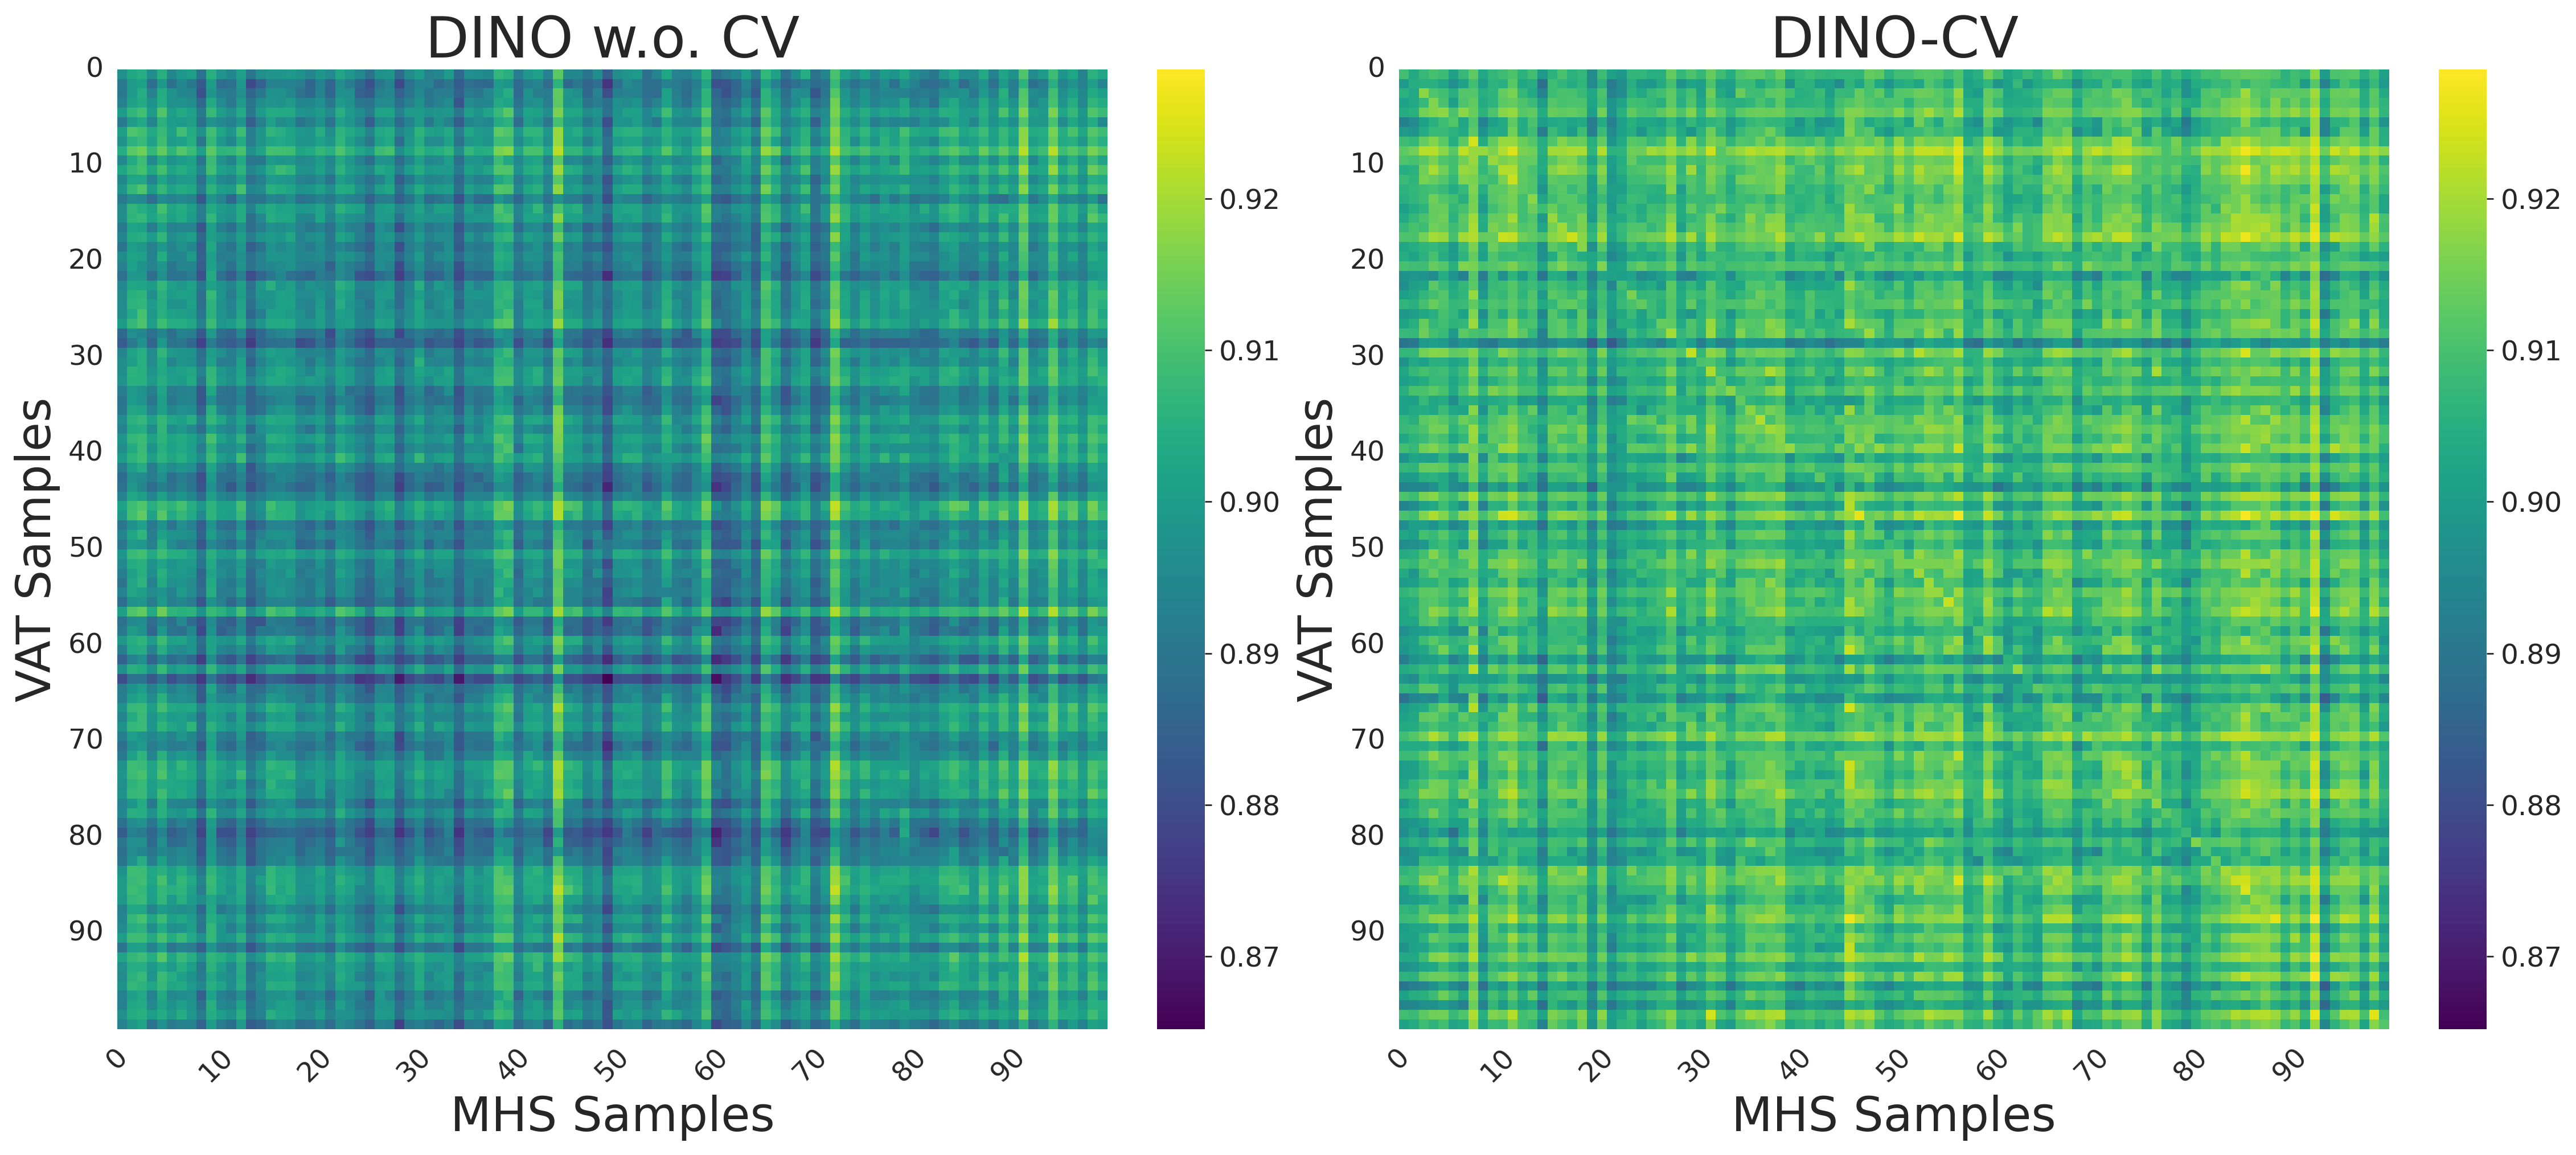

In [6]:
sim_dino = sample_wise_similarities_dino
sim_dino_cv = sample_wise_similarities_dino_cv

# Compute shared color range
sim_min = min(sim_dino.min().item(), sim_dino_cv.min().item())
sim_max = max(sim_dino.max().item(), sim_dino_cv.max().item())

n_vat, n_mhs = sim_dino.shape

# Tick spacing interval
tick_interval = max(n_mhs // 10, 1)
xticks = np.arange(0, n_mhs, tick_interval)
yticks = np.arange(0, n_vat, tick_interval)

# Create grid with more space for individual color bars
fig, axs = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.01})

# DINO heatmap with its own colorbar
cbar1 = sns.heatmap(sim_dino.cpu().numpy(), cmap='viridis', vmin=sim_min, vmax=sim_max,
                    ax=axs[0], cbar=True)
axs[0].set_title('DINO w.o. CV')
axs[0].set_xlabel('MHS Samples')
axs[0].set_ylabel('VAT Samples')
axs[0].set_xticks(xticks)
axs[0].set_yticks(yticks)
axs[0].set_xticklabels(xticks, rotation=45, fontsize=14)
axs[0].set_yticklabels(yticks, rotation=0, fontsize=14)
cbar1.collections[0].colorbar.ax.tick_params(labelsize=14)

# DINO-CV heatmap with its own colorbar
cbar2 = sns.heatmap(sim_dino_cv.cpu().numpy(), cmap='viridis', vmin=sim_min, vmax=sim_max,
                    ax=axs[1], cbar=True)
axs[1].set_title('DINO-CV')
axs[1].set_xlabel('MHS Samples')
axs[1].set_ylabel('VAT Samples')
axs[1].set_xticks(xticks)
axs[1].set_yticks(yticks)
axs[1].set_xticklabels(xticks, rotation=45, fontsize=14)
axs[1].set_yticklabels(yticks, rotation=0, fontsize=14)
cbar2.collections[0].colorbar.ax.tick_params(labelsize=14)

plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.1)
plt.savefig(f"figs/rn50_feat_sim.png", dpi=300)
# plt.show()

In [7]:
arch = 'vit_small'
backbone = 'vitsmall16'

dino_cv_mhs_backbone = build_model(
    arch, 
    'load',
    f'./save/pretrained_weights/dino_cv/{backbone}_mhs_budjbim_pretrained/checkpoint.pth',
    256,
    16
)
dino_cv_mhs_backbone.fc = torch.nn.Identity()
dino_cv_mhs_backbone.to('cuda')

dino_cv_vat_backbone = build_model(
    arch, 
    'load',
    f'./save/pretrained_weights/dino_cv/{backbone}_vat_budjbim_pretrained/checkpoint.pth',
    256,
    16
)
dino_cv_vat_backbone.fc = torch.nn.Identity()
dino_cv_vat_backbone.to('cuda')

dino_mhs_backbone = build_model(
    arch, 
    'load',
    f'./save/pretrained_weights/dino_base/{backbone}_mhs_budjbim_pretrained/checkpoint.pth',
    256,
    16
)
dino_mhs_backbone.fc = torch.nn.Identity()
dino_mhs_backbone.to('cuda')

dino_vat_backbone = build_model(
    arch, 
    'load',
    f'./save/pretrained_weights/dino_base/{backbone}_vat_budjbim_pretrained/checkpoint.pth',
    256,
    16
)
dino_vat_backbone.fc = torch.nn.Identity()
dino_vat_backbone.to('cuda')

Take key teacher in provided checkpoint dict
Pretrained weights found at ./save/pretrained_weights/dino_cv/vitsmall16_mhs_budjbim_pretrained/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Initialized model 'vit_small' with self-supervised pre-trained weights.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./save/pretrained_weights/dino_cv/vitsmall16_vat_budjbim_pretrained/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Initialized model 'vit_small' with self-supervised pre-trained weights.
Take key teacher in provided checkpoint dict

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1-11): 11 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (a

In [8]:
# # Each of these will be a list of per-area lists
mhs_outputs_dino = []
vat_outputs_dino = []

mhs_outputs_dino_cv = []
vat_outputs_dino_cv = []

# # Per-area feature lists
area_mhs_dino = []
area_vat_dino = []

area_mhs_dino_cv = []
area_vat_dino_cv = []

for i in range(len(dataset)):
    data = dataset[i]

    # Load data
    mhs = data['mhs'].unsqueeze(0).to('cuda')  # shape: [1, C, H, W]
    vat = data['vat'].unsqueeze(0).to('cuda')

    with torch.no_grad():
        # Encode with DINO
        mhs_dino = dino_mhs_backbone(mhs)
        vat_dino = dino_vat_backbone(vat)

        # Encode with DINO-CV
        mhs_cv = dino_cv_mhs_backbone(mhs)
        vat_cv = dino_cv_vat_backbone(vat)

    # Store features (detach + squeeze batch dim)
    mhs_outputs_dino.append(mhs_dino.squeeze(0).cpu())
    vat_outputs_dino.append(vat_dino.squeeze(0).cpu())

    mhs_outputs_dino_cv.append(mhs_cv.squeeze(0).cpu())
    vat_outputs_dino_cv.append(vat_cv.squeeze(0).cpu())

In [9]:
vat_dino = torch.stack(vat_outputs_dino)       # [N, D]
mhs_dino = torch.stack(mhs_outputs_dino)       # [N, D]

vat_dino_cv = torch.stack(vat_outputs_dino_cv) # [N, D]
mhs_dino_cv = torch.stack(mhs_outputs_dino_cv) # [N, D]

# Normalize features
vat_dino = F.normalize(vat_dino, dim=1)
mhs_dino = F.normalize(mhs_dino, dim=1)
vat_dino_cv = F.normalize(vat_dino_cv, dim=1)
mhs_dino_cv = F.normalize(mhs_dino_cv, dim=1)

# Compute cosine similarity matrices
sim_dino = torch.matmul(vat_dino, mhs_dino.T)         # [N, N]
sim_dino_cv = torch.matmul(vat_dino_cv, mhs_dino_cv.T) # [N, N]

sample_wise_similarities_dino = sim_dino
sample_wise_similarities_dino_cv = sim_dino_cv

print(f"DINO w/o CV similarity matrix shape: {sim_dino.shape}")
print(f"DINO-CV similarity matrix shape: {sim_dino_cv.shape}")

print("Mean paired cosine similarity of DINO w/o CV:", sim_dino.diag().mean().item())
print("Mean paired cosine similarity of DINO-CV:", sim_dino_cv.diag().mean().item())

DINO w/o CV similarity matrix shape: torch.Size([100, 100])
DINO-CV similarity matrix shape: torch.Size([100, 100])
Mean paired cosine similarity of DINO w/o CV: 0.26956015825271606
Mean paired cosine similarity of DINO-CV: 0.33322224020957947


/tmp/ipykernel_21233/1470111694.py:42: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.1)


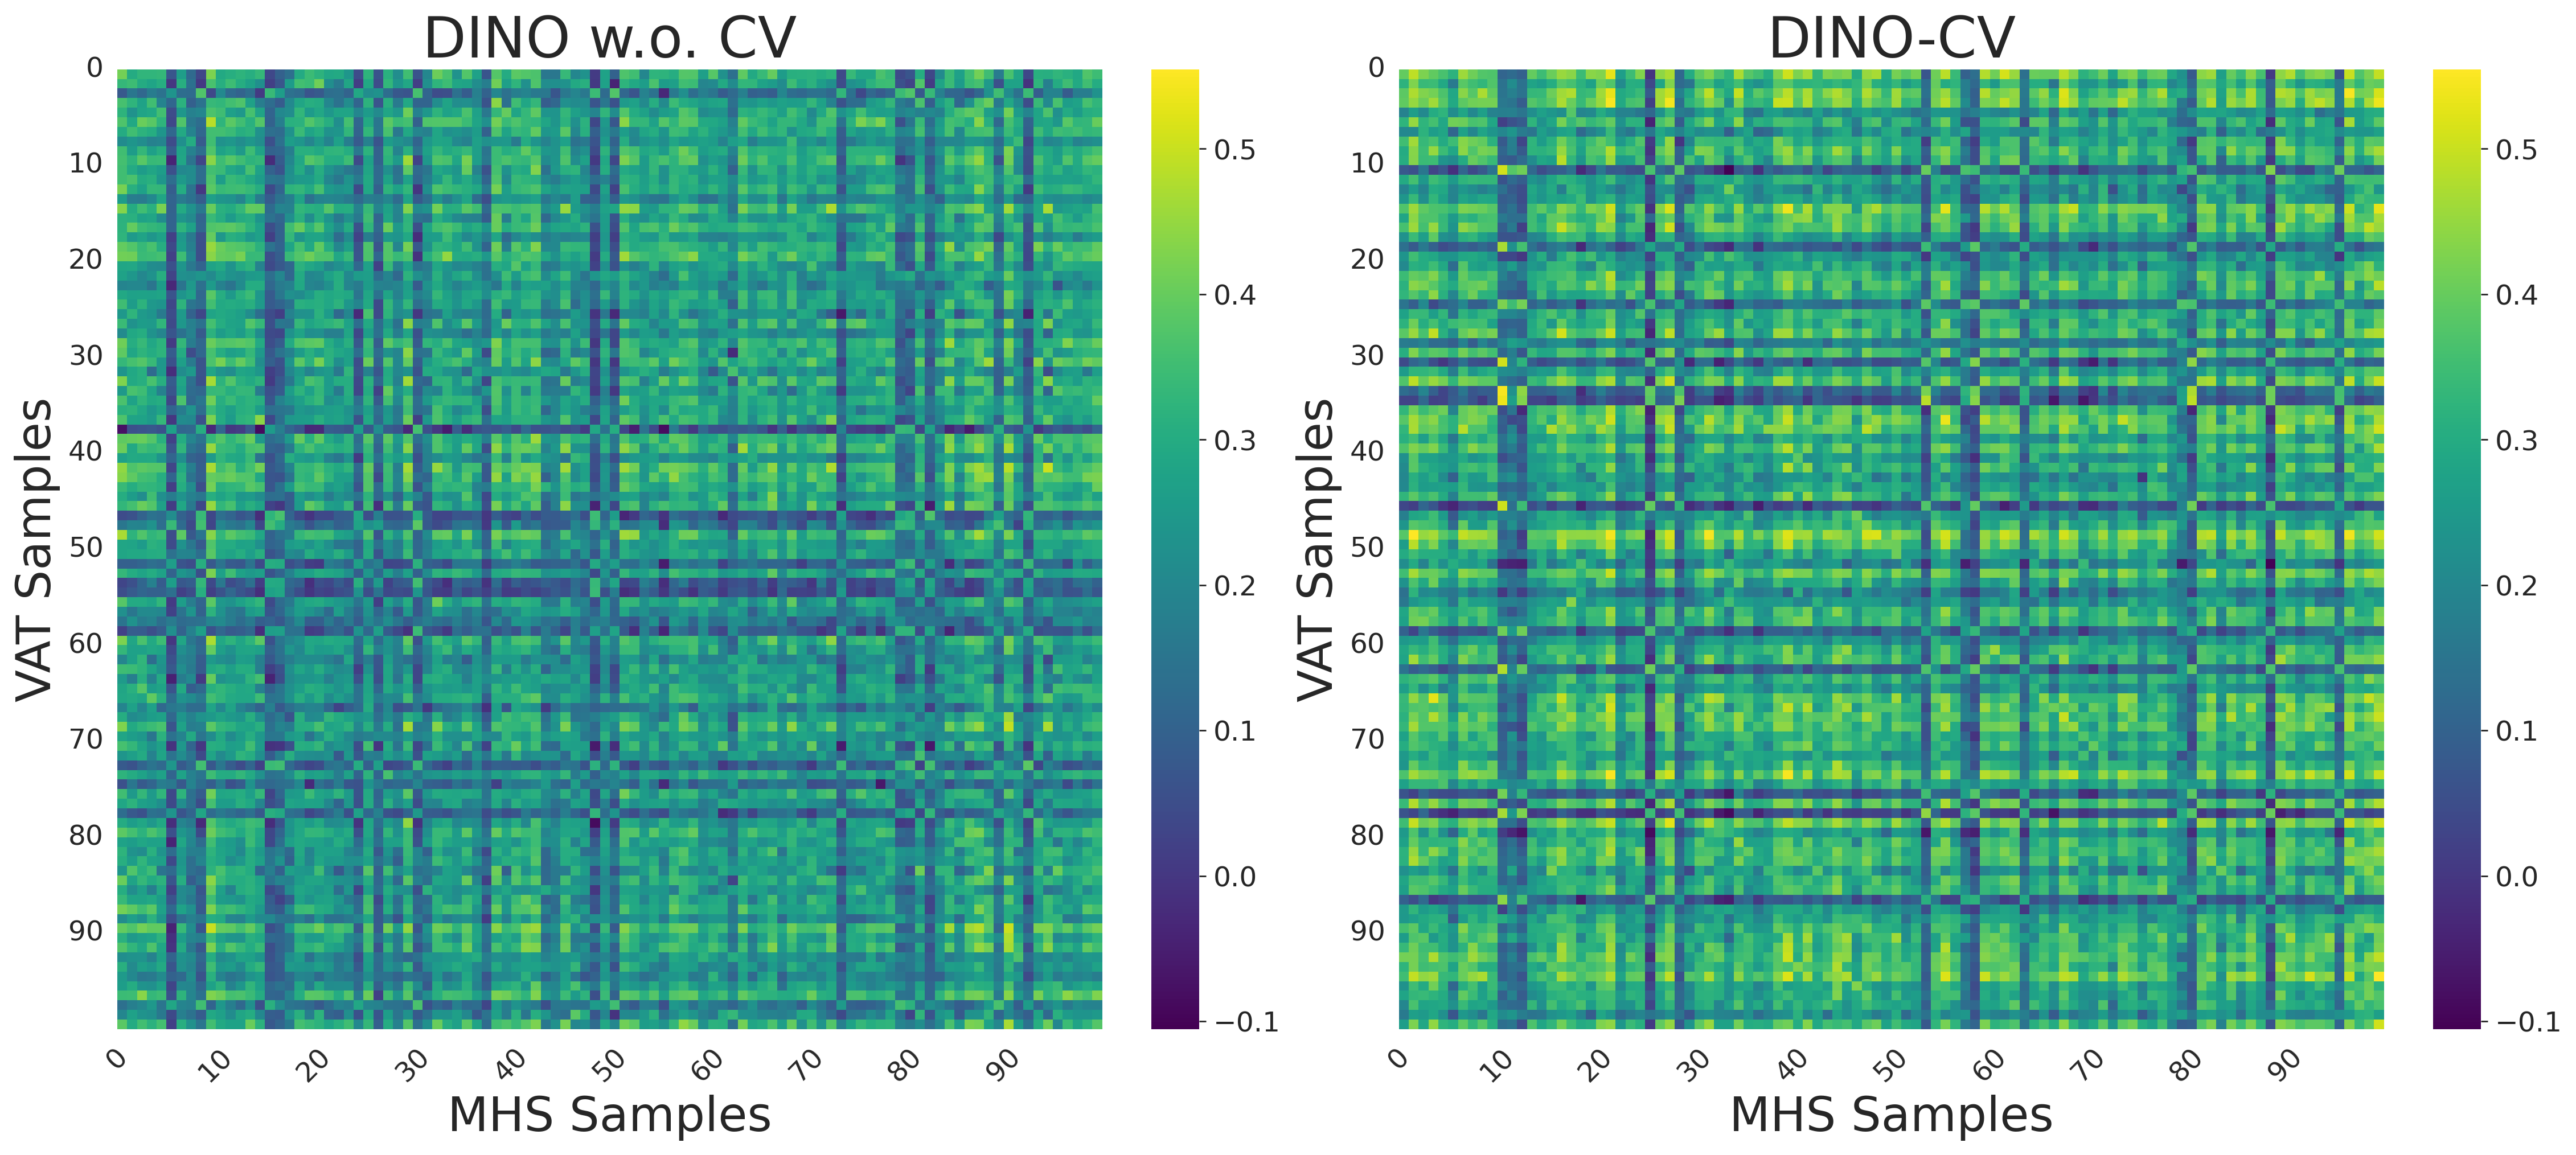

In [10]:
sim_dino = sample_wise_similarities_dino
sim_dino_cv = sample_wise_similarities_dino_cv

# Compute shared color range
sim_min = min(sim_dino.min().item(), sim_dino_cv.min().item())
sim_max = max(sim_dino.max().item(), sim_dino_cv.max().item())

n_vat, n_mhs = sim_dino.shape

# Tick spacing interval
tick_interval = max(n_mhs // 10, 1)
xticks = np.arange(0, n_mhs, tick_interval)
yticks = np.arange(0, n_vat, tick_interval)

# Create grid with more space for individual color bars
fig, axs = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.01})

# DINO heatmap with its own colorbar
cbar1 = sns.heatmap(sim_dino.cpu().numpy(), cmap='viridis', vmin=sim_min, vmax=sim_max,
                    ax=axs[0], cbar=True)
axs[0].set_title('DINO w.o. CV')
axs[0].set_xlabel('MHS Samples')
axs[0].set_ylabel('VAT Samples')
axs[0].set_xticks(xticks)
axs[0].set_yticks(yticks)
axs[0].set_xticklabels(xticks, rotation=45, fontsize=14)
axs[0].set_yticklabels(yticks, rotation=0, fontsize=14)
cbar1.collections[0].colorbar.ax.tick_params(labelsize=14)

# DINO-CV heatmap with its own colorbar
cbar2 = sns.heatmap(sim_dino_cv.cpu().numpy(), cmap='viridis', vmin=sim_min, vmax=sim_max,
                    ax=axs[1], cbar=True)
axs[1].set_title('DINO-CV')
axs[1].set_xlabel('MHS Samples')
axs[1].set_ylabel('VAT Samples')
axs[1].set_xticks(xticks)
axs[1].set_yticks(yticks)
axs[1].set_xticklabels(xticks, rotation=45, fontsize=14)
axs[1].set_yticklabels(yticks, rotation=0, fontsize=14)
cbar2.collections[0].colorbar.ax.tick_params(labelsize=14)

plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.1)
plt.savefig(f"figs/vit_feat_sim.png", dpi=300)
# plt.show()